*   **Dataset**: cognitive load data - testing all channels
*   **Kernels**: WL, Spectral Decomposition, Random Walk
*   **Classifiers**: Decision Tree, Random Forest, SVC




In [1]:
!pip install mne
!pip install graphkit-learn
from os import listdir
from os.path import isfile, join
import mne
import tqdm
import numpy as np
import networkx as nx
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid, StratifiedKFold, KFold
from sklearn.base import clone
import numbers
import time
from sklearn.utils.metaestimators import _safe_split
from sklearn.metrics._scorer import _MultimetricScorer
from contextlib import suppress
from joblib import logger
from sklearn.model_selection import cross_val_score
from sklearn.utils.validation import _num_samples
from traceback import format_exc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import collections
import matplotlib.pyplot as plt

import datetime
timestamp = datetime.datetime.now()
timestamp = timestamp.timestamp() * 1000
timestamp = str(timestamp)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 43.8 MB/s eta 0:00:00


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("drive/My Drive/Journal_Executions")

Mounted at /content/drive


In [34]:
data_path = 'Data_BCIHCI/S02/'
label_map  = {"Idle": 0, "Dual-1-Back": 1}

all_files = {
    "Idle": listdir(join(data_path, "Idle")),
    "Dual-1-Back": listdir(join(data_path, "Dual-1-Back")),
    # "1-Back": listdir(join(data_path, "1-Back")),
    # "2-Back": listdir(join(data_path, "2-Back")),
    # "Dual-2-Back": listdir(join(data_path, "Dual-2-Back"))
}

graphs = []
labels_list = []
# adj_matrix = []

# Constants
fs = 128                          # Sampling frequency
idle_duration = 5 * fs            # 5 seconds of idle, converted to samples

for label, files in all_files.items():
  for filename in files:
    file_path = join(data_path, label, filename)

    print('File:', file_path)

    edf = mne.io.read_raw_edf(file_path)
    edf.load_data()
    # print(edf.ch_names)
    # ['COUNTER', 'INTERPOLATED', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'RAW_CQ', 'GYROX', 'GYROY',
    #  'MARKER', 'SYNC', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_CMS', 'CQ_DRL']
    edf.pick(edf.ch_names[2:16])
    # ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

    channel_data = edf.get_data()
    # print(edf.ch_names)

    #Perform data cleaning :- remove channels having all zeros
    noiserow=[]
    for i in np.arange(0, channel_data.shape[0]):
         if np.sum(channel_data[i])==0:
            noiserow.append(i)
    channel_data=np.delete(channel_data, noiserow, axis=0)
    num_channels=channel_data.shape[0]

    experiment_data = channel_data

    # Define epochs within the experiment period
    NEpoch=int(experiment_data.shape[1]/(3*128))

    data=np.zeros((NEpoch,num_channels*num_channels))
    # adj_matrix = np.zeros((NEpoch, num_channels, num_channels))

    # k=0
    for i in range(NEpoch):
      epoch = experiment_data[:,3*i*128:3*(i+1)*128]
      cor_mat = np.corrcoef(epoch)
      if np.isnan(cor_mat).any():
          continue
      # cor_mat[np.abs(cor_mat) < 0.5] = 0
      # cor_mat[np.abs(cor_mat) >= 0.5] = 1

      # adj_matrix[k] = cor_mat

      # Binarization of Adjacency matrix
      th=np.percentile(cor_mat.flatten(),35)
      # print('threshold value:', th)
      cor_mat[cor_mat<th]=0
      cor_mat[cor_mat>=th]=1

      graph = nx.from_numpy_array(cor_mat)
      # print('label:::', label)
      graphs.append(graph)
      labels_list.append(label_map[label])

print('GRAPHS', len(graphs))


from gklearn.kernels.weisfeilerLehmanKernel import weisfeilerlehmankernel
kernel = 'weisfeilerlehmankernel'
kernel_matrix = weisfeilerlehmankernel(
    graphs,
    node_label='atom',
    edge_label='bond_type',
    height=3,
    base_kernel='subtree',
    parallel=None,
    n_jobs=None,
    verbose=True)



'''
from gklearn.kernels import SpectralDecomposition
import multiprocessing

kernel = 'SpectralDecomposition'
graph_kernel = SpectralDecomposition(
    ds_infos=graphs,
    weight=0.1,
    p=None,
    q=None,
    edge_weight=None,
    sub_kernel='exp'
)

kernel_matrix = graph_kernel.compute(
    graphs,
    parallel=None,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

from gklearn.kernels.randomWalkKernel import randomwalkkernel
from gklearn.utils.kernels import deltakernel, gaussiankernel, kernelproduct
import functools
import multiprocessing

kernel = 'RW'
mixkernel = functools.partial(kernelproduct, deltakernel, gaussiankernel)
sub_kernels = [{'symb': deltakernel, 'nsymb': gaussiankernel, 'mix': mixkernel}]
sub_kernel = ['geo', 'exp']
compute_method = 'conjugate'

kernel = 'RandomWalk'
kernel_matrix = randomwalkkernel(
			graphs,
			compute_method=compute_method,
			weight=0.001,
			p=None,
			q=None,
			edge_weight=None,
			node_kernels=sub_kernels,
			edge_kernels=sub_kernels,
			node_label='atom',
			edge_label='bond_type',
			sub_kernel=sub_kernel,
			n_jobs=multiprocessing.cpu_count(),
			verbose=True
		)
'''



File: Data_BCIHCI/S02/Idle/S02-01-25.09.2016.11.12.43.edf
Extracting EDF parameters from /content/drive/MyDrive/Journal_Executions/Data_BCIHCI/S02/Idle/S02-01-25.09.2016.11.12.43.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24191  =      0.000 ...   188.992 secs...
File: Data_BCIHCI/S02/Dual-1-Back/S02-01-25.09.2016.11.42.51.edf
Extracting EDF parameters from /content/drive/MyDrive/Journal_Executions/Data_BCIHCI/S02/Dual-1-Back/S02-01-25.09.2016.11.42.51.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23551  =      0.000 ...   183.992 secs...
GRAPHS 124

 --- Weisfeiler-Lehman subtree kernel matrix of size 124 built in 0.6059587001800537 seconds ---


"\nfrom gklearn.kernels import SpectralDecomposition\nimport multiprocessing\n\nkernel = 'SpectralDecomposition'\ngraph_kernel = SpectralDecomposition(\n    ds_infos=graphs,\n    weight=0.1,\n    p=None,\n    q=None,\n    edge_weight=None,\n    sub_kernel='exp'\n)\n\nkernel_matrix = graph_kernel.compute(\n    graphs,\n    parallel=None,\n    n_jobs=multiprocessing.cpu_count(),\n    verbose=True\n)\n\nfrom gklearn.kernels.randomWalkKernel import randomwalkkernel\nfrom gklearn.utils.kernels import deltakernel, gaussiankernel, kernelproduct\nimport functools\nimport multiprocessing\n\nkernel = 'RW'\nmixkernel = functools.partial(kernelproduct, deltakernel, gaussiankernel)\nsub_kernels = [{'symb': deltakernel, 'nsymb': gaussiankernel, 'mix': mixkernel}]\nsub_kernel = ['geo', 'exp']\ncompute_method = 'conjugate'\n\nkernel = 'RandomWalk'\nkernel_matrix = randomwalkkernel(\n\t\t\tgraphs,\n\t\t\tcompute_method=compute_method,\n\t\t\tweight=0.001,\n\t\t\tp=None,\n\t\t\tq=None,\n\t\t\tedge_weigh

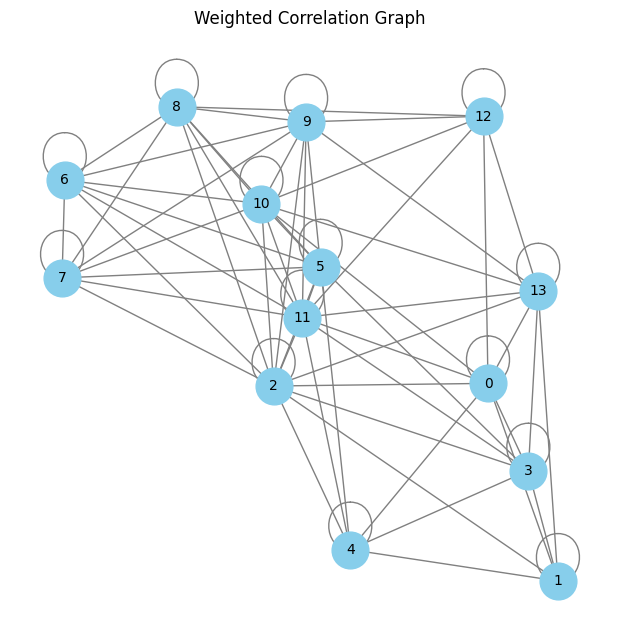

In [35]:

plt.figure(figsize=(6, 6))
graph_weighted = nx.from_numpy_array(cor_mat)

pos = nx.spring_layout(graph)  # Spring layout for better visualization
nx.draw(graph_weighted, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=700, font_size=10)
plt.title('Weighted Correlation Graph')
plt.show()

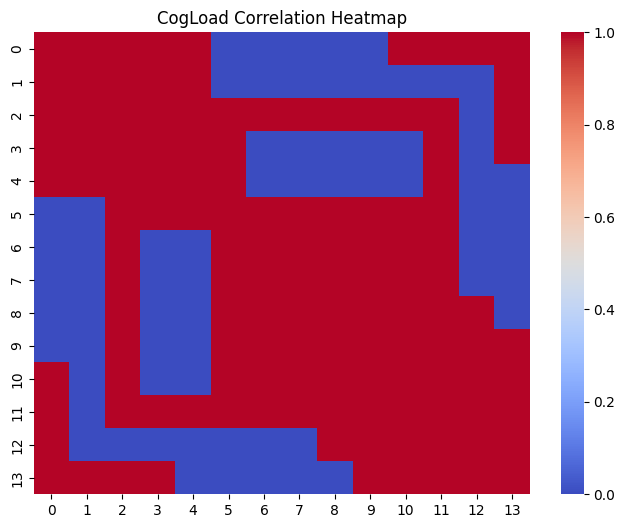

In [36]:
plt.figure(figsize=(8, 6))
import seaborn as sns
sns.heatmap(cor_mat, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('CogLoad Correlation Heatmap')
plt.show()


In [48]:
# kernel_matrix[0]
# print('np.max(kernel_matrix[0]):::::::::::::', np.max(kernel_matrix[0]))
# print('np.min(kernel_matrix[0]):::::::::::::', np.min(kernel_matrix[0]))
#
print('Kernel:::::::::::::', kernel_matrix[0])

from sklearn.decomposition import PCA, KernelPCA
kpca = KernelPCA(kernel='rbf', gamma=0.1)
gram_kpca = kpca.fit_transform(kernel_matrix[0])

X=gram_kpca
y=labels_list

print('X:::::::::::::', X.shape)
print('y:::::::::::::', len(y))

Kernel::::::::::::: [[308. 264. 230. ... 211. 219. 210.]
 [264. 422. 227. ... 207. 215. 208.]
 [230. 227. 290. ... 222. 220. 211.]
 ...
 [211. 207. 222. ... 270. 221. 219.]
 [219. 215. 220. ... 221. 260. 222.]
 [210. 208. 211. ... 219. 222. 260.]]
X::::::::::::: (124, 123)
y::::::::::::: 124


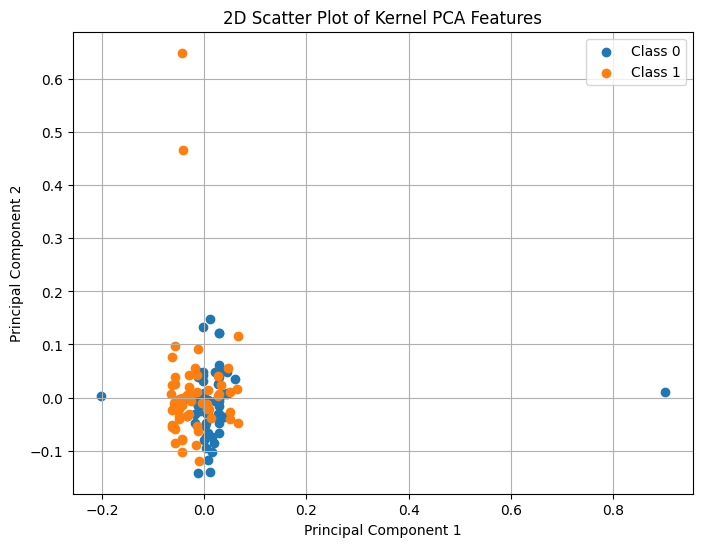

In [51]:
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(X[y == label, 0], X[y == label, 1], label=f"Class {label}")
plt.title("2D Scatter Plot of Kernel PCA Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

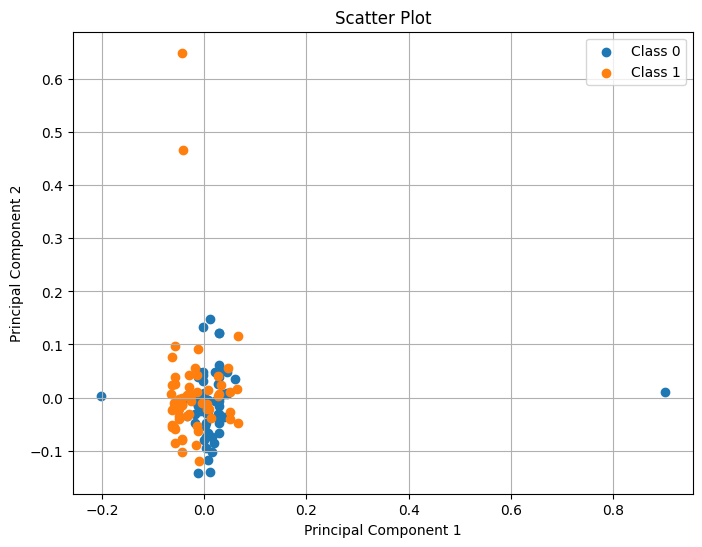

In [62]:
 plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(X[y == label, 0], X[y == label, 1], label=f"Class {label}")
plt.title('Scatter Plot')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


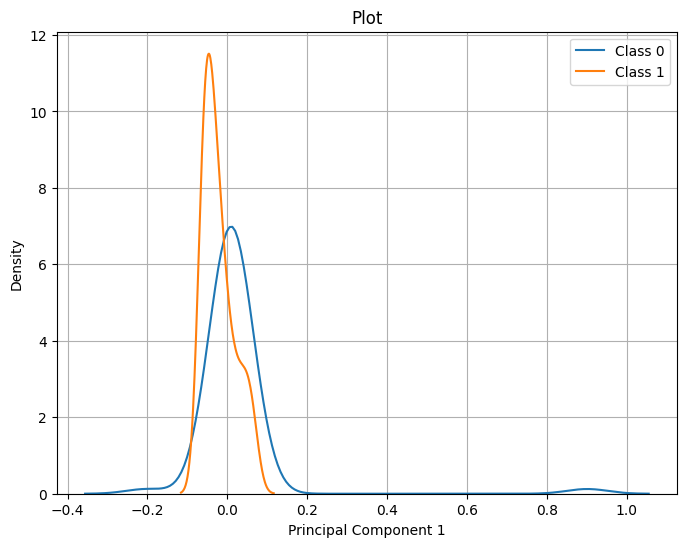

In [64]:
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    sns.kdeplot(X[y == label, 0], label=f"Class {label}")
plt.title('Plot')
plt.xlabel("Principal Component 1")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


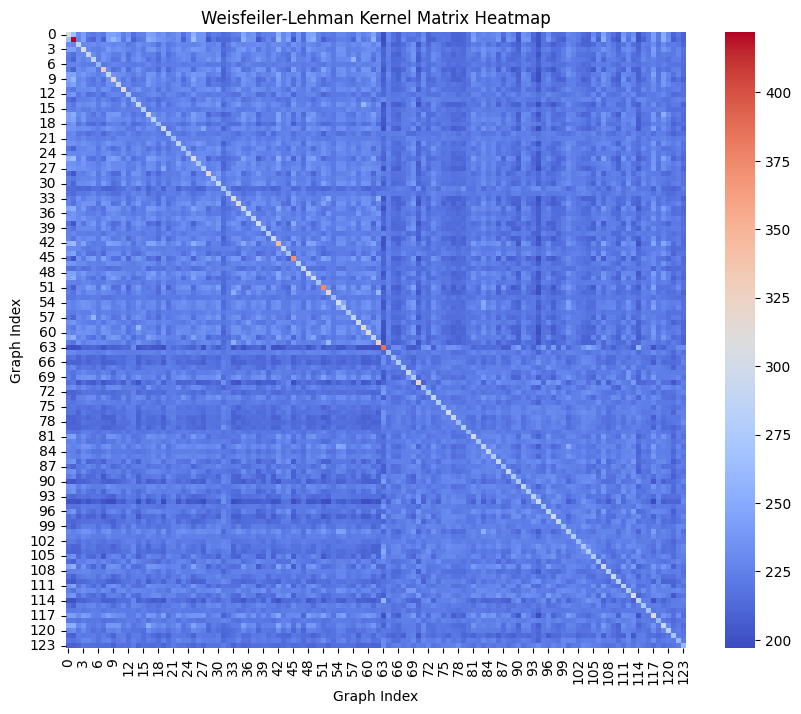

In [66]:
import seaborn as sns
import numpy as np

# Example kernel matrix (replace with your actual kernel_matrix after computation)
# kernel_matrix = np.random.random((len(graphs), len(graphs)))

plt.figure(figsize=(10, 8))
sns.heatmap(kernel_matrix[0], cmap='coolwarm', annot=False)
plt.title("Weisfeiler-Lehman Kernel Matrix Heatmap")
plt.xlabel("Graph Index")
plt.ylabel("Graph Index")
plt.show()

In [65]:
print('Kernel:::', kernel)
print('data_path:::', data_path)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pdb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

# from sklearn.feature_selection import SelectKBest, f_classif
# selector = SelectKBest(score_func=f_classif, k='all')
# X_train = selector.fit_transform(X_train, y_train)
# X_test = selector.transform(X_test)

# Define the parameter grids for each model
param_grid_svc = {
  'C': [0.01, 0.1, 1, 10, 100],
  'kernel': ['linear', 'rbf', 'poly'],
  'gamma': ['scale', 'auto'],
  'class_weight': ['balanced', None]
}

param_grid_rf = {
  'n_estimators': [50, 100, 200],
  'max_depth': [None, 10, 20, 30],
  'min_samples_split': [2, 5, 10],
  'max_features': ['sqrt', 'log2'],  # Number of features to consider for splits
  'class_weight': ['balanced', None]
}

param_grid_dt = {
  'max_depth': [None, 10, 20, 30],
  'min_samples_split': [2, 5, 10],
  'class_weight': ['balanced', None]
}

from sklearn.utils.class_weight import compute_class_weight

# # Compute class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y_train)
# class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# # Initialize the models
# svc = SVC(class_weight=class_weights_dict, random_state=42)
# rf = RandomForestClassifier(oob_score=True, class_weight=class_weights_dict, random_state=42)
# dt = DecisionTreeClassifier(class_weight=class_weights_dict, random_state=42)


svc = SVC(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(oob_score=True, class_weight='balanced', random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Perform grid search for each model
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search
grid_search_svc.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_dt.fit(X_train, y_train)

# Get the best estimators
best_svc = grid_search_svc.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_dt = grid_search_dt.best_estimator_


# Best estimator and evaluation
# print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
# print(f"OOB Score: {best_rf.oob_score_:.4f}")

print('best_svc', best_svc)
print('best_rf', best_rf)
print('best_dt', best_dt)

# Evaluate each model and print accuracy and AUC
models = { 'Decision Tree': best_dt, 'Random Forest': best_rf, 'SVC': best_svc }
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Display metrics
    results[name] = {'accuracy': accuracy, 'auc_score': auc_score, 'precision': precision, 'recall': recall, 'f1': f1}
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, precision:{precision:.4f}, recall: {recall:.4f}, f1: {f1:.4f}")

    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {scores.mean():.4f}")


Kernel::: weisfeilerlehmankernel
data_path::: Data_BCIHCI/S02/
best_svc SVC(C=0.01, class_weight='balanced', kernel='linear', random_state=42)
best_rf RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       n_estimators=200, oob_score=True, random_state=42)
best_dt DecisionTreeClassifier(class_weight='balanced', random_state=42)
Decision Tree - Accuracy: 0.8400, AUC: 0.8365, precision:0.8480, recall: 0.8400, f1: 0.8384
Decision Tree Cross-Validation Accuracy: 0.6830
Random Forest - Accuracy: 0.9600, AUC: 1.0000, precision:0.9631, recall: 0.9600, f1: 0.9600
Random Forest Cross-Validation Accuracy: 0.7460
SVC - Accuracy: 0.4800, AUC: 0.5000, precision:0.2304, recall: 0.4800, f1: 0.3114
SVC Cross-Validation Accuracy: 0.5080


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


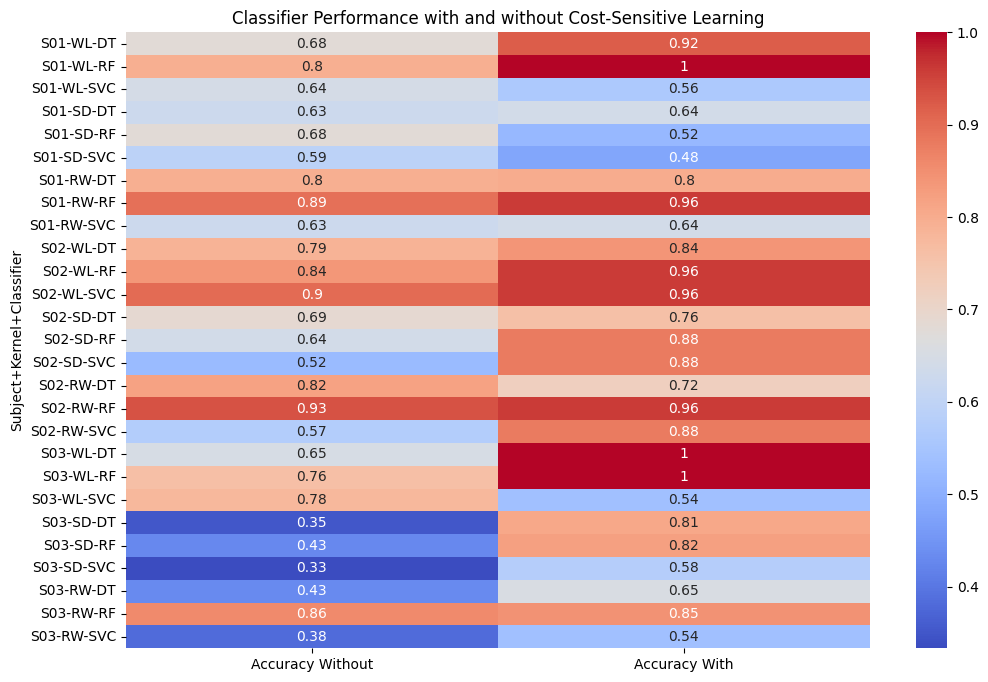

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data for the table
data = {
    'Subject+Kernel+Classifier': ['S01-WL-DT', 'S01-WL-RF', 'S01-WL-SVC', 'S01-SD-DT', 'S01-SD-RF', 'S01-SD-SVC',
                                  'S01-RW-DT', 'S01-RW-RF', 'S01-RW-SVC', 'S02-WL-DT', 'S02-WL-RF', 'S02-WL-SVC',
                                  'S02-SD-DT', 'S02-SD-RF', 'S02-SD-SVC', 'S02-RW-DT', 'S02-RW-RF', 'S02-RW-SVC',
                                  'S03-WL-DT', 'S03-WL-RF', 'S03-WL-SVC', 'S03-SD-DT', 'S03-SD-RF', 'S03-SD-SVC',
                                  'S03-RW-DT', 'S03-RW-RF', 'S03-RW-SVC'],
    'Accuracy Without': [0.678, 0.7966, 0.6441, 0.6271, 0.678, 0.5932, 0.7966, 0.8938, 0.6271, 0.7869, 0.8361, 0.9016,
                         0.6885, 0.6393, 0.5246, 0.8197, 0.9344, 0.5738, 0.6508, 0.7619, 0.7778, 0.3492, 0.4286, 0.3333,
                         0.4311, 0.8571, 0.381],
    'Accuracy With': [0.92, 1, 0.56, 0.64, 0.52, 0.48, 0.8, 0.96, 0.64, 0.84, 0.96, 0.96, 0.76, 0.88, 0.88, 0.72, 0.96,
                      0.88, 1, 1, 0.5385, 0.8077, 0.8214, 0.5774, 0.6538, 0.8462, 0.5385]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the index to 'Subject+Kernel+Classifier'
df.set_index('Subject+Kernel+Classifier', inplace=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Classifier Performance with and without Cost-Sensitive Learning')
plt.show()


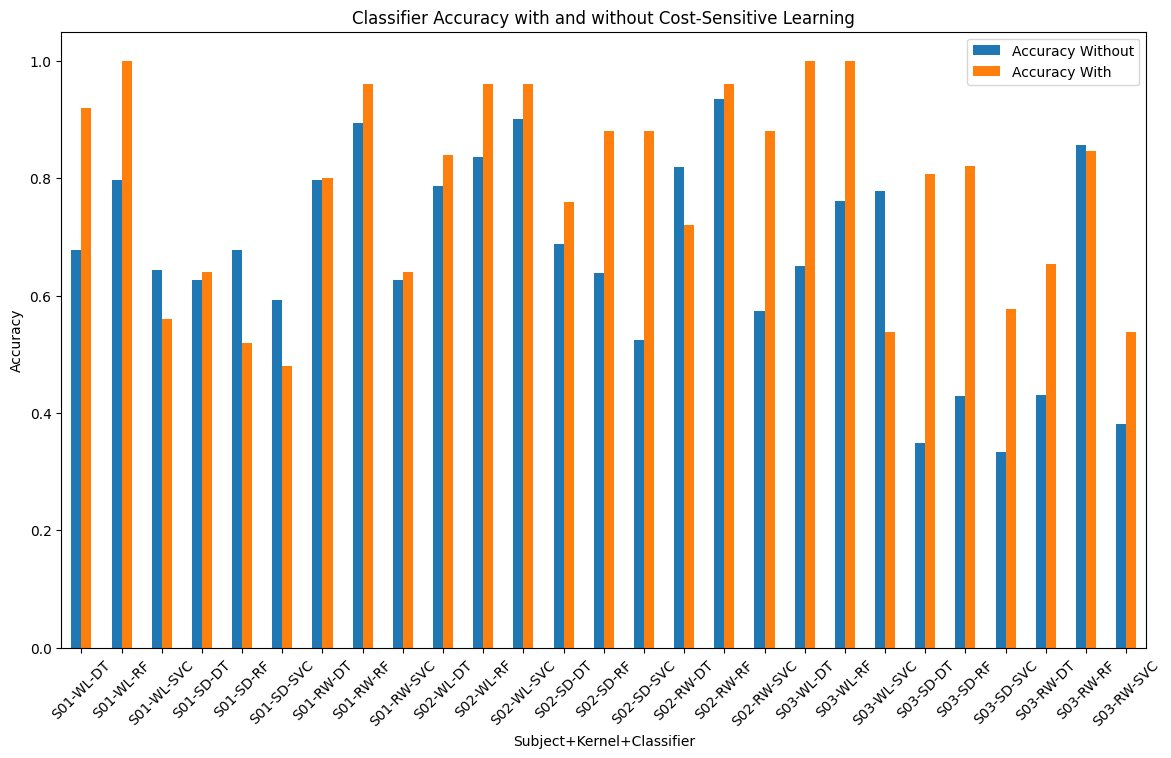

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for the table
data = {
    'Subject+Kernel+Classifier': ['S01-WL-DT', 'S01-WL-RF', 'S01-WL-SVC', 'S01-SD-DT', 'S01-SD-RF', 'S01-SD-SVC', 'S01-RW-DT', 'S01-RW-RF', 'S01-RW-SVC',
                                  'S02-WL-DT', 'S02-WL-RF', 'S02-WL-SVC', 'S02-SD-DT', 'S02-SD-RF', 'S02-SD-SVC', 'S02-RW-DT', 'S02-RW-RF', 'S02-RW-SVC',
                                  'S03-WL-DT', 'S03-WL-RF', 'S03-WL-SVC', 'S03-SD-DT', 'S03-SD-RF', 'S03-SD-SVC', 'S03-RW-DT', 'S03-RW-RF', 'S03-RW-SVC'],
    'Accuracy Without': [0.678, 0.7966, 0.6441, 0.6271, 0.678, 0.5932, 0.7966, 0.8938, 0.6271,
                         0.7869, 0.8361, 0.9016, 0.6885, 0.6393, 0.5246, 0.8197, 0.9344, 0.5738,
                         0.6508, 0.7619, 0.7778, 0.3492, 0.4286, 0.3333, 0.4311, 0.8571, 0.381 ],

    'Accuracy With': [0.92, 1, 0.56, 0.64, 0.52, 0.48, 0.8, 0.96, 0.64, 0.84, 0.96, 0.96, 0.76, 0.88, 0.88, 0.72, 0.96,
                      0.88, 1, 1, 0.5385, 0.8077, 0.8214, 0.5774, 0.6538, 0.8462, 0.5385]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the index to 'Subject+Kernel+Classifier'
df.set_index('Subject+Kernel+Classifier', inplace=True)

# Bar chart for accuracy
df[['Accuracy Without', 'Accuracy With']].plot(kind='bar', figsize=(14, 8))
plt.title('Classifier Accuracy with and without Cost-Sensitive Learning')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()


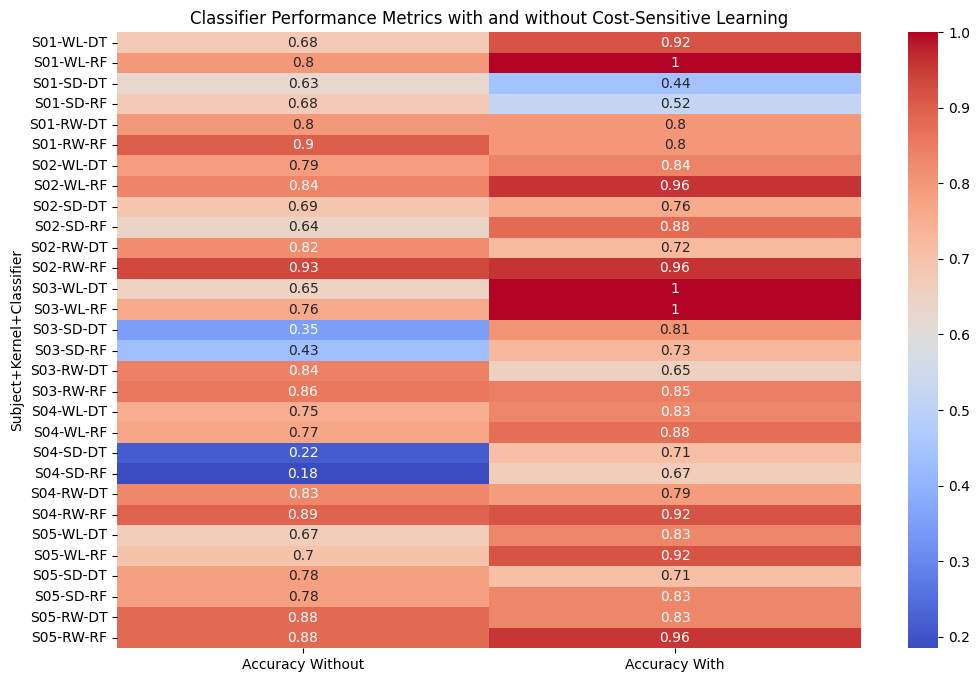

In [79]:
# Example data for other metrics
data = {
    'Subject+Kernel+Classifier': ['S01-WL-DT', 'S01-WL-RF', 'S01-SD-DT', 'S01-SD-RF', 'S01-RW-DT', 'S01-RW-RF',
                                  'S02-WL-DT', 'S02-WL-RF', 'S02-SD-DT', 'S02-SD-RF', 'S02-RW-DT', 'S02-RW-RF',
                                  'S03-WL-DT', 'S03-WL-RF', 'S03-SD-DT', 'S03-SD-RF', 'S03-RW-DT', 'S03-RW-RF',
                                  'S04-WL-DT', 'S04-WL-RF', 'S04-SD-DT', 'S04-SD-RF', 'S04-RW-DT', 'S04-RW-RF',
                                  'S05-WL-DT', 'S05-WL-RF', 'S05-SD-DT', 'S05-SD-RF', 'S05-RW-DT', 'S05-RW-RF'],
    'Accuracy Without': [ 0.678, 0.7966, 0.6271, 0.678,  0.7966, 0.8983,
                         0.7869, 0.8361, 0.6885, 0.6393, 0.8197, 0.9344,
                         0.6508, 0.7619, 0.3492, 0.4286, 0.8413, 0.8571,
                         0.7538, 0.7692, 0.2154, 0.1846, 0.8308, 0.8923,
                         0.6667, 0.7,    0.7833, 0.7833, 0.8833, 0.8833 ],

    'Accuracy With': [ 0.92,   1,      0.44,   0.52,   0.8,    0.8,
                       0.84,   0.96,   0.76,   0.88,   0.72,   0.96,
                       1,      1,      0.8077, 0.7308, 0.6538, 0.8462,
                       0.8333, 0.8750, 0.7083, 0.6667, 0.7917, 0.9167,
                       0.8333, 0.9167, 0.7083, 0.8333, 0.8333, 0.9583 ]
}

# Create a DataFrame
df_metrics = pd.DataFrame(data)
df_metrics.set_index('Subject+Kernel+Classifier', inplace=True)

# Plot heatmap for performance metrics
plt.figure(figsize=(12, 8))
sns.heatmap(df_metrics, annot=True, cmap='coolwarm', cbar=True)
plt.title('Classifier Performance Metrics with and without Cost-Sensitive Learning')
plt.show()


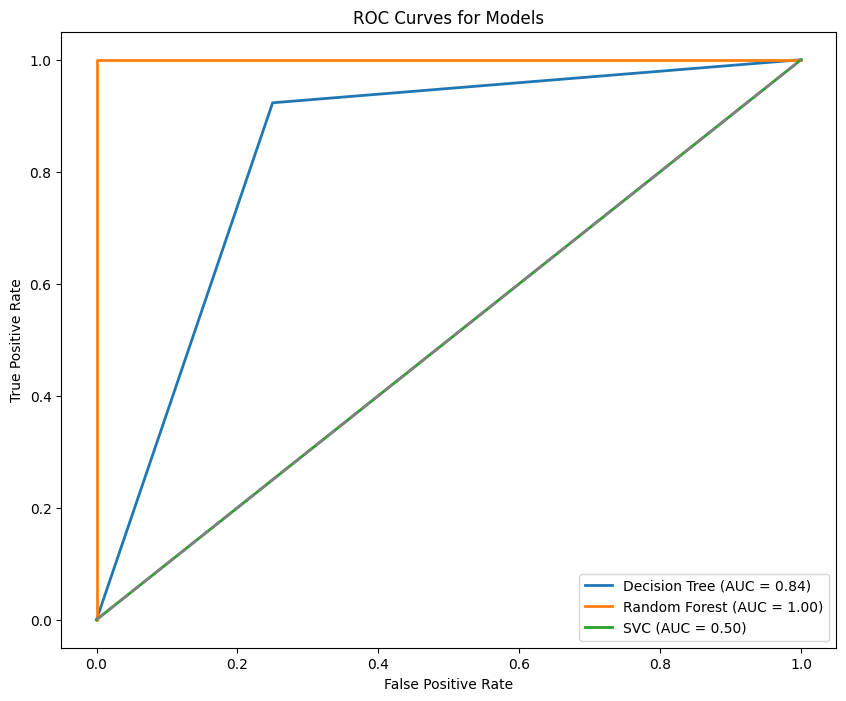

In [80]:
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models')
plt.legend(loc='lower right')
plt.show()


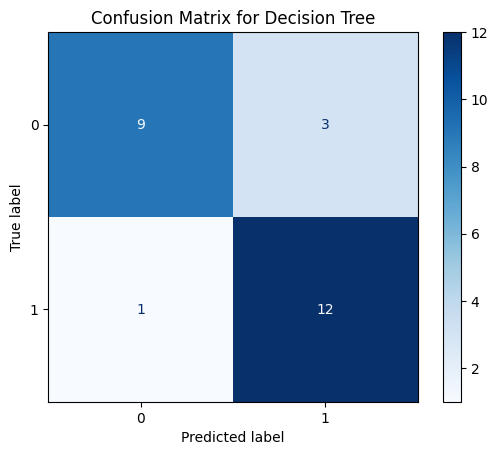

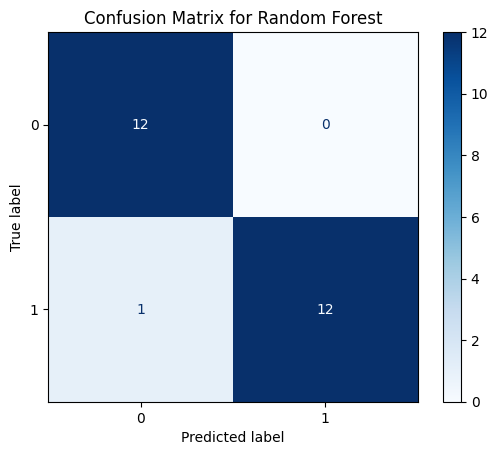

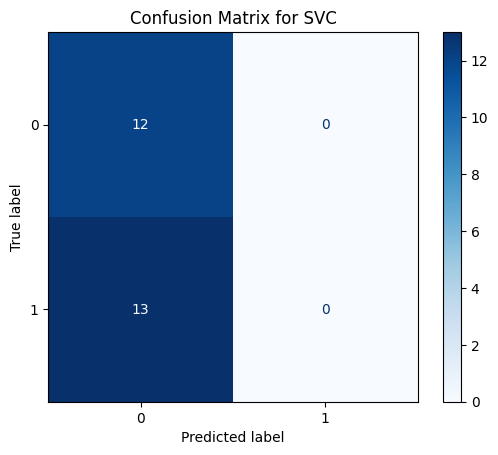

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for name, model in models.items():
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.show()